# Modeling recruitment decisions with scikit-learn

In this notebook we'll apply regression to a classification problem in order to predict the likelihood of getting hired. The target variable that we are predicting is therefore a binary "Yes" or "No" decision called **`Status`** in our Match table. 

Based on my assumptions of the recruitment process the important features to get recruited at this french client are:

- The Reactivity metric which we will call **`Response time`** throughout the notebook. This time lapse is defined as the difference between the moment the CV is received by the client and the moment when the candidate is accepted or refused for an interview ie. **`4. Client initial validation date - 4. CV sent to Client`**. What we seek to evaluate here is: "How fast does the client react to CVs?"
- The Efficiency metric is the timelapse that follows the previous step which we will call **`Decision time`** throughout the notebook. This time lapse is the difference between the moment the candidate is accepted for interview and the decision to hire is made ie.  **`7. Client final approval date - 4. Client initial validation date`**. What we seek to evaluate here is: "How fast does the client move when the right person is found?"
- **`French_level`** of the candidate which is called "Language level (French)" in our dataset. We believe this variable to be positively correlated with the decision to hire
- Number of relevant years of experience: we'll approximate it with the **`Experience`** variable for now which is the total years of experience

We'll define a null hypothesis for each of these features which we will then try to reject by comparing the probability distribution of the sample of candidates that got hired vs the distribution of the sample of candidates that were not hired. We won't however go into the math or details behind this and instead use a library called statsmodels.api to assist us on the task. If you are interested in going deeper into the math behind I highly recommend visiting the series Python for data analysis series in hamelg's blog link below


Credits: this notebook is highly inspired by : <a href="https://www.kaggle.com/humananalog/xgboost-lasso">Human Analog's contribution on Kaggle</a> 
, <a href="https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8">Susan Li's article 1</a> , <a href="https://datascienceplus.com/building-a-logistic-regression-in-python-step-by-step/">Susan Li's article 2</a> and this <a href="http://hamelg.blogspot.pt/2015/11/python-for-data-analysis-part-23-point.html">blog</a> 

## Overview
1. Importing useful libraries and loading data in
2. Preliminary EDA: Exploratory data analysis
3. Munging/Feature Engineering
4. Test the statistical significance of our variables
5. Split, train and predict/infer on our test set
6. Evaluate the model's performance
7. Visualize the model's decision boundary and sample classification
8. Model selection and tuning
9. Key take aways
10. Conclusion

## 1. Importing useful libraries and loading data in

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
sns.set()

%matplotlib inline 
# useful so that we do not need to repeat the plt.show() command everytime we want a graph displayed

CV_Match = pd.read_excel("data.xlsx", sheetname = "Match", index_col = 'Candidate_match') 
CV_Sourcing = pd.read_excel("data.xlsx", sheetname = "Candidate", index_col = 'CV_ID')
# read in the data from a xlsx and define an index for each of the dataframes

## 2. Preliminary EDA: Exploratory data analysis

In [174]:
print(len(CV_Match.columns),"columns in the Match table")
print(len(CV_Sourcing.columns),"columns in the Candidate table")

5 columns in the Match table
2 columns in the Candidate table


In [175]:
CV_Match["Status"].unique()

array(['Rejected', 'CV refused', 'Candidate refused',
       'A03 - Offer declined', 'D01 – Resignation', 'A05 - Onboarding',
       'Candidate dropped out', 'CV dropped out', 'T01- Terminated',
       'A03 - Process Cancelled', 'Dropped out', 'Approved',
       'CV sent to France', 'Matched', 'Candidate validated',
       'A01 - Offer Preparation Started',
       'A04b – Hiring Started / Contract signed', 'A03 - Offer accepted',
       'CV approved', 'A04 - Hiring Request Started', 'Sent to Client'],
      dtype=object)

In [176]:
status_go_match = [
'A01 - Offer Preparation Started',
'A02 - Offer Sent to Candidate',
'A03 - Offer accepted',
'A03 - Offer declined',
'A03 - Process Cancelled',
'A04 - Hiring Request Started',
'A04a – Hiring Sta`ted / Collecting signatures',
'A04b – Hiring Started / Contract signed',
'A05 - Onboarding',
'A06 - Offboarding',
'B01 - Subcontracting Started',
'B02 - Subcontracting Signed',
'D01 – Resignation',
'T01- Terminated',
'Candidate validated']

CV_Match_go = CV_Match[CV_Match["Status"].isin(status_go_match)]

print("""CV_Match: Input data has {} lines, out of which we had {} GOs ({:.1f}%), Our target variable is highly skewed so when
computing the performance of our model we can't use accuracy as a measure of how good the model is. 
The reason why we don't use accuracy as a measure of performance here is because if our model predict y = 0 all the time 
it would still fare pretty decently: {:.1f} %
""".format(CV_Match.shape[0],CV_Match_go.shape[0],(CV_Match_go.shape[0]/CV_Match.shape[0])*100,(1-(CV_Match_go.shape[0]/CV_Match.shape[0]))*100))

CV_Match: Input data has 2255 lines, out of which we had 347 GOs (15.4%), Our target variable is highly skewed so when
computing the performance of our model we can't use accuracy as a measure of how good the model is. 
The reason why we don't use accuracy as a measure of performance here is because if our model predict y = 0 all the time 
it would still fare pretty decently: 84.6 %



## 3. Munging/Feature Engineering

In [177]:
'''
INDEX & MATCH EXPERIENCE AND FR LEVEL FROM THE CANDIDATE TABLE
'''

# build 2 series with the FR level and Exp levels we want to index into our Match dataframe
FR_level = CV_Sourcing["Language Level - French"][CV_Sourcing["Language Level - French"].notnull()]
Exp = CV_Sourcing["Experience"][CV_Sourcing["Experience"].notnull()]

# build an empty dataframe to join the 2 series
shell = pd.DataFrame(index = CV_Sourcing.index)
shell['FR_level'] = FR_level
shell['Experience'] = Exp
#shell.count()

#concatenate the two series into our Match table
CV_Match = pd.concat([CV_Match,shell], axis = 1, join_axes= [CV_Match.index])

#Now that we concatenated on the foreign key of the Match table let's set the primary key as the index 

CV_Match.set_index('Match_ID', inplace=True)

In [178]:
'''
ADD 2 NEW COMPUTED FEATURES: Response Time and Decision Time
'''

CV_Match['Response Time'] = CV_Match['4. Client initial validation date'] - CV_Match['4. CV sent to Client']
CV_Match['Response Time'] = CV_Match['Response Time'].dt.days

CV_Match['Decision Time'] = CV_Match['7. Client final approval date'] - CV_Match['4. Client initial validation date']
CV_Match['Decision Time'] = CV_Match['Decision Time'].dt.days


In [179]:
'''
MAP STATUS TO ZEROS AND ONES
YES GO --> 1 
NO  GO --> 0
'''

Status_map_1 = {
'Rejected':0,
'CV refused':0,
'A02 - Offer Sent to Candidate':1,
'Candidate refused':0,
'A03 - Offer declined':1,
'D01 – Resignation':1,
'A05 - Onboarding':1,
'Candidate dropped out':0,
'CV dropped out':0,
'T01- Terminated':1,
'A03 - Process Cancelled':1,
'Dropped out':0,
'Approved':0,
'CV sent to France':0,
'Matched':0,
'Candidate validated':1,
'A01 - Offer Preparation Started':1,
'A04b – Hiring Started / Contract signed':1,
'A03 - Offer accepted':1,
'CV approved':0,
'A04 - Hiring Request Started':1,
'Sent to Client':0
}


CV_Match['Match_Status_mapped'] = CV_Match['Status'].map(Status_map_1).astype(int)

In [180]:
'''
REMOVE ABSURD DATA
'''

drop_Response_Time = CV_Match.index[CV_Match['Response Time'] < 0].tolist()
drop_Decision_Time = CV_Match.index[CV_Match['Decision Time'] < 0].tolist()
'''
drop_Response_Time2 = CV_Match.index[CV_Match['Response Time'] > 300].tolist()
drop_Decision_Time2 = CV_Match.index[CV_Match['Decision Time'] > 300].tolist()
'''
# Append to list

c = drop_Response_Time + drop_Decision_Time# + drop_Response_Time2 + drop_Decision_Time2
e = drop_Response_Time# + drop_Response_Time2 
f = drop_Decision_Time# + drop_Decision_Time2

'''
Dropping the 98 missing values actually yields the same result on the prediction 
so we'll stick to replacing by the mean for now

Instead of replacing the 98 missing values by the mean of the column dropping the empty lines could be done by running:
CV_Match.drop(c, inplace = True)

'''
for i, item in enumerate(e):
    CV_Match.loc[item, "Response Time"] = CV_Match["Response Time"].mean()
for i, item in enumerate(f):
    CV_Match.loc[item, "Decision Time"] = CV_Match["Decision Time"].mean()


In [181]:
"""
DROP THE COLUMNS WE WONT USE IN OUR MODEL
"""
all_data = CV_Match[['Match_Status_mapped', 'FR_level', 'Experience', 'Response Time', 'Decision Time']] 

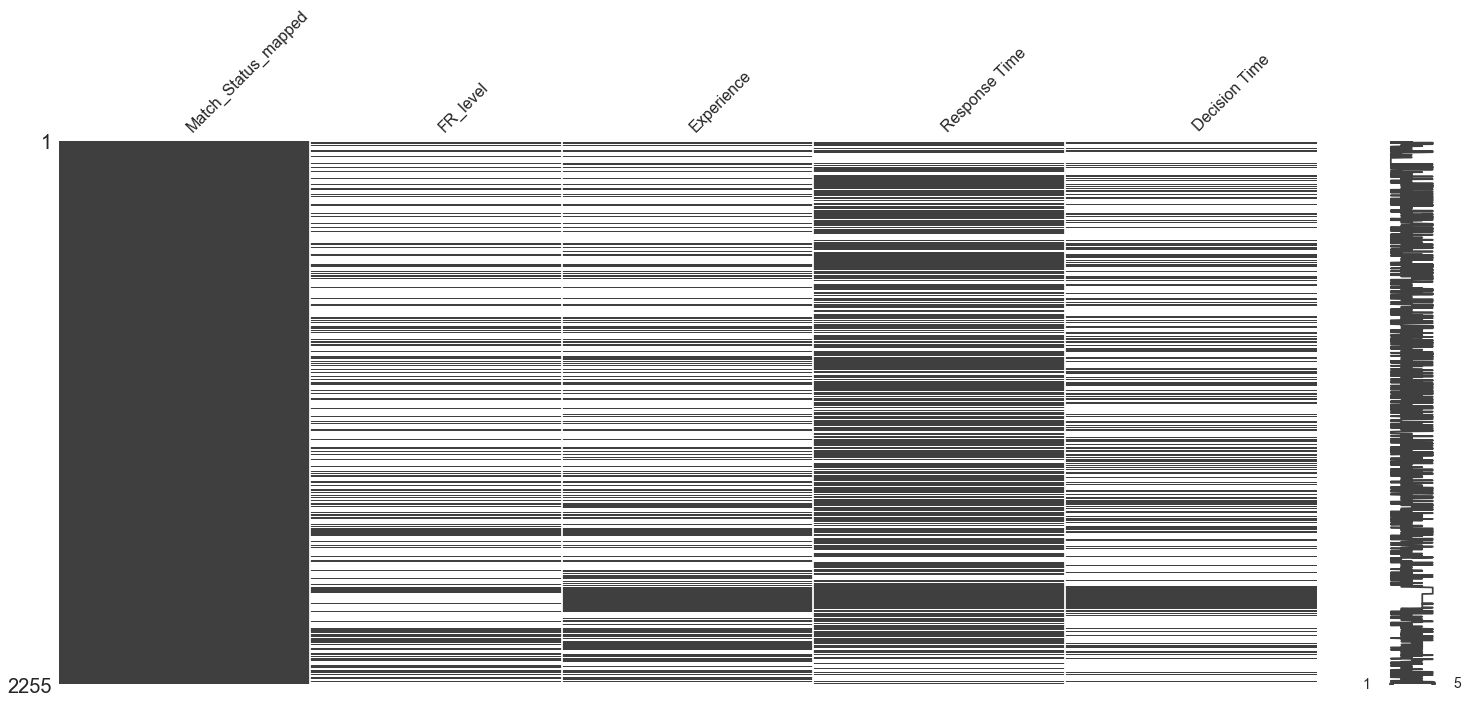

In [182]:
"""
DISPLAY THE MISSING DATA
"""
msno.matrix(all_data)

The white spaces above represent the missing values in our columns.There are a lot of missing values in our samples which is bad for 2 reasons:

1. The model has less predictive power since it has less data to train on 
2. And secondly we can't feed datasets with missing values to sklearn libraries so there is no way around it

We will have to either drop the empty lines or replace it by some kind of proxy. We will have to study all possibilities and the final method we will take will be the one that positively impacts the model's performance

In [183]:
# Replace missing values with a 0
all_data['FR_level'] = all_data['FR_level'].fillna("0")

# drop data where the experience level of the candidate is missing
all_data = all_data[all_data['Experience'].notnull()]

all_data.skew()

Match_Status_mapped    0.187861
Response Time          5.161424
Decision Time          3.789535
dtype: float64

We'll have to correct this high skewness .skew() > 0.75, with either log transformation or Box Cox

In [184]:
print(all_data.describe())

       Match_Status_mapped  Response Time  Decision Time
count           750.000000     608.000000     430.000000
mean              0.453333      14.636513      30.260471
std               0.498150      54.278564      75.289881
min               0.000000       0.000000       0.000000
25%               0.000000       0.000000       0.000000
50%               0.000000       0.000000       7.000000
75%               1.000000       5.000000      16.750000
max               1.000000     413.000000     453.000000


We could get away without scaling because the ranges of our features are close but we'll still perform feature scaling to confirm this assumption

,Candidate is a GO,Candidate is a NO GO
Response Time,,
0.0,102,221
1.0,37,42
2.0,9,10
3.0,5,9
4.0,6,5
5.0,14,4
6.0,9,11
7.0,6,6
8.0,1,2


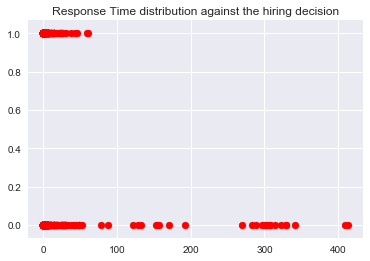

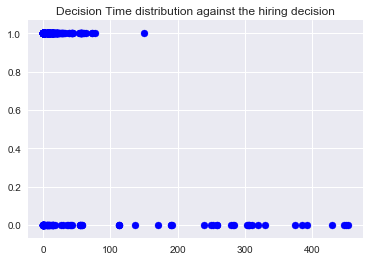

In [185]:
# let's explore the relationships within our data by using scatter plots and frequency tables
plt.title('Response Time distribution against the hiring decision')
plt.scatter(all_data['Response Time'],all_data['Match_Status_mapped'],color='red')

plt.figure()
plt.title('Decision Time distribution against the hiring decision')
plt.scatter(all_data['Decision Time'],all_data['Match_Status_mapped'],color='blue')

"""
Getting rid of that outlier actually worsened the performance of the model so let's roll back and keep the outlier
all_data['Match_Status_mapped'][all_data['Match_Status_mapped']==1].groupby(all_data['Decision Time']).describe() 
lets get rid of that outlier at 150 as it might negatively impact our model's bility to generalize
all_data['Decision Time'][all_data['Match_Status_mapped']==1][all_data['Decision Time'][all_data['Match_Status_mapped']==1]>=150]
we found the outlier id = "10047" let's adjust our initial data munging operation 
to drop that line or replace it by some kind of proxy 

"""

table = pd.crosstab(all_data['Response Time'],all_data['Match_Status_mapped'])
table.columns = ['Candidate is a GO','Candidate is a NO GO']
table.head(10)


Key take aways:

1) The client is generally extremely responsive towards our candidates as we can judge from the table and scatter above

2) Most candidates end up getting a reply within the same day

3) The distribution then has a long tail of mainly no go's

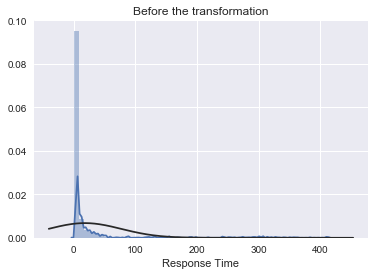

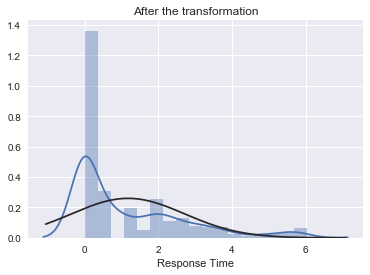

In [186]:
# Let's normalize the distributions to reduce the skew identified earlier

from scipy.stats import norm, skew
from scipy.special import boxcox1p

temp = CV_Match['Response Time'].dropna()+1
plt.title('Before the transformation')
sns.distplot(CV_Match['Response Time'].dropna(),fit = norm)

plt.figure()
plt.title('After the transformation')

sns.distplot(temp.apply(np.log),fit = norm)
#sns.distplot(boxcox1p(temp,0.2),fit = norm)

We'll have to transform the probability distribution of **`Response Time`** and **`Decision Time`** to fit it to a Gaussian curve as it is an assumption of the inferential model we'll be using. 
The resulting transformations do not perfectly mirror a gaussian curve but let's go with that for now

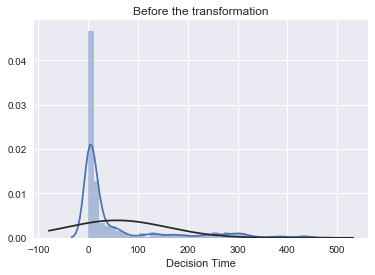

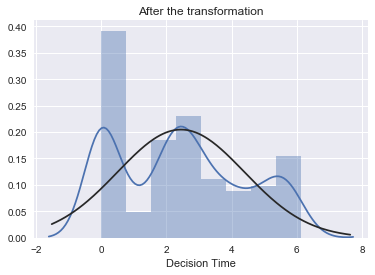

In [187]:
# Let's normalize the distribution
from scipy.stats import norm, skew

temp = CV_Match['Decision Time'].dropna()+1
plt.title('Before the transformation')

sns.distplot(CV_Match['Decision Time'].dropna(),fit = norm)

plt.figure()
plt.title('After the transformation')

sns.distplot(temp.apply(np.log),fit = norm)
#sns.distplot(boxcox1p(temp,0.2),fit = norm)

We'll transform the probability distribution of **`Response Time`** and **`Decision Time`** in the next section

**`French_level`** and **`Experience`** however do a worse job at emulating the gaussian curve with the transformation so we won't transform these two variables.

In [188]:
"""
LABEL ENCODE IN ORDER TO PREDICT ON CERTAIN CATEGORIES OF DATA
"""
# split the decision times into groups of 20 day periods
Decision_map = pd.concat(pd.Series(str(i+1), index=range(i*20,20+i*20)) for i in range(0, (np.ceil(all_data["Decision Time"].max()/20)).astype(int)))

all_data['Response_Time'] = all_data['Response Time'].map(Decision_map)
all_data['Decision_Time'] = all_data['Decision Time'].map(Decision_map)

# replace Decision time by the log of Decision time
temp = all_data['Decision_Time'].astype(float).dropna()
all_data['Decision_Time'] = temp.apply(np.log)

# replace Response time by the log of Response time
temp = all_data['Response_Time'].astype(float).dropna()
all_data['Response_Time'] = temp.apply(np.log)

#describe the data so that we get a sense of the distribution of the variable we just mapped
groupby = all_data['Decision_Time'].groupby(all_data['Decision_Time']).describe()
groupby['index'] = groupby.index.astype(int)
groupby = groupby.sort_values(by=['index'])
groupby.drop('index', axis=1, inplace=True)

# drop the original columns and rename the target/dependant variable
all_data.drop(['Response Time','Decision Time'], axis = 1, inplace = True)
all_data.rename(index=str, columns={"Match_Status_mapped": "y"}, inplace = True)

#display the groupby
groupby

,count,mean,std,min,25%,50%,75%,max
Decision_Time,,,,,,,,
0.000000,334.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
0.693147,34.0,0.693147,1.126919e-16,0.693147,0.693147,0.693147,0.693147,0.693147
1.098612,11.0,1.098612,2.328823e-16,1.098612,1.098612,1.098612,1.098612,1.098612
1.386294,5.0,1.386294,0.000000e+00,1.386294,1.386294,1.386294,1.386294,1.386294
1.791759,3.0,1.791759,2.719480e-16,1.791759,1.791759,1.791759,1.791759,1.791759
1.945910,1.0,1.945910,NaN,1.945910,1.945910,1.945910,1.945910,1.945910
2.995732,2.0,2.995732,0.000000e+00,2.995732,2.995732,2.995732,2.995732,2.995732
2.944439,1.0,2.944439,NaN,2.944439,2.944439,2.944439,2.944439,2.944439
2.833213,1.0,2.833213,NaN,2.833213,2.833213,2.833213,2.833213,2.833213


In [189]:
"""
Map the sample data with this scikit-learn encoder which basically replaces the unique values by an int,
this operation does not create new columns

"""

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(all_data['Experience'].unique())
all_data['Experience'] = le.transform(all_data['Experience'])

le.fit(all_data['FR_level'].unique())
all_data['FR_level'] = le.transform(all_data['FR_level'])
all_data['FR_level'] = all_data['FR_level'].fillna('0')

In [190]:
# remove missing values NaN from our columns

Response_Time_ID = []
Decision_Time_ID = []

Response_Time_ID = list(all_data["Response_Time"][all_data["Response_Time"].isnull()].index)
Decision_Time_ID = list(all_data["Decision_Time"][all_data["Decision_Time"].isnull()].index)
FR_level_ID = list(all_data["FR_level"][all_data["FR_level"].isnull()].index)

Response_Time_ID.extend(Decision_Time_ID) # adds Decision times elements at the end of the first list
Response_Time_ID.extend(FR_level_ID) # adds Decision times elements at the end of the first list

mylist = list(set(Response_Time_ID)) # convert to a set so that we remove the duplicates otherwise the drop lines method fails

all_data.drop(mylist, inplace = True)

"""
print(all_data["Response_Time"].isnull().any())
print(all_data["Decision_Time"].isnull().any())
print(all_data['FR_level'].isnull().any())
print(all_data['FR_level'].unique())
""";

In [191]:
#Keep a copy (without the dummy cariable so that we can graph the decision boundary later on

X_ = all_data.drop(['y'], axis = 1)
y_ = all_data['y']

In [192]:
"""
FURTHER ENCODE IN ORDER TO PREPARE FOR THE ONE HOT ENCODE
"""
Status_map_1 = {
0:0,
1:0,
2:0,
3:1,
4:1,
5:1,
6:1,
7:1
}

#don't skip values to map even if redundant otherwise the unmapped statuses will be mapped to NaN

Status_map_2 = {
0:0,
1:0,
2:1,
3:1

}

all_data['Experience'] = all_data['Experience'].map(Status_map_2)
all_data['FR_level'] = all_data['FR_level'].map(Status_map_1)

"""
print(all_data['Experience'].unique())
print(all_data['FR_level'].unique())
#print(all_data['Response_Time'].unique())
#print(all_data['Decision_Time'].unique())

print(all_data["Response_Time"].isnull().any())
print(all_data["Decision_Time"].isnull().any())
print(all_data["FR_level"].isnull().any())
print(all_data["Experience"].isnull().any())
""";

In [193]:
"""
One hot encode our features. 
This operation simply transforms our features into vectors of zeros and ones and creates new columns with those vectors

"""

def onehot(df, column):
    dummies = pd.get_dummies(df[column], prefix="_" + column)
    df = df.join(dummies, how='outer')
    df.drop([column], axis=1, inplace=True)
    return df

#col_list = all_data.columns.tolist()
col_list = ['FR_level', 'Experience']

for column in col_list:
    if column != "y":
        all_data = onehot(all_data, column)

In [194]:
print(all_data.head())

          y  Response_Time  Decision_Time  _FR_level_0  _FR_level_1  \
Match_ID                                                              
10008     1            0.0       1.386294            1            0   
10010     1            0.0       0.000000            1            0   
10011     1            0.0       0.000000            0            1   
10012     1            0.0       0.693147            0            1   
10013     1            0.0       0.000000            0            1   

          _Experience_0  _Experience_1  
Match_ID                                
10008                 0              1  
10010                 1              0  
10011                 0              1  
10012                 0              1  
10013                 0              1  


In [195]:
"""
Set the X and y matrices that will be fed to the model
"""
#all_data.rename(index=str, columns={"_Experience_1": "Experience",'_FR_level_1.0':'FR_level'}, inplace = True)

y = all_data['y']
X = all_data.drop(['y','_Experience_0','_FR_level_0'], axis = 1)

# adding an intercept negatively impacts our model so we'll skip this step
# manually add the intercept
#X['intercept'] = 1.0


In [214]:
"""
KEEP A DATASET FOR CROSSVALIDATION
"""

param = 100

X = X[:-param]
y = y[:-param]

X_CV = X[:param]
y_CV = y[:param]

"""
print(X_CV.index)
print(y_CV.index)
""";

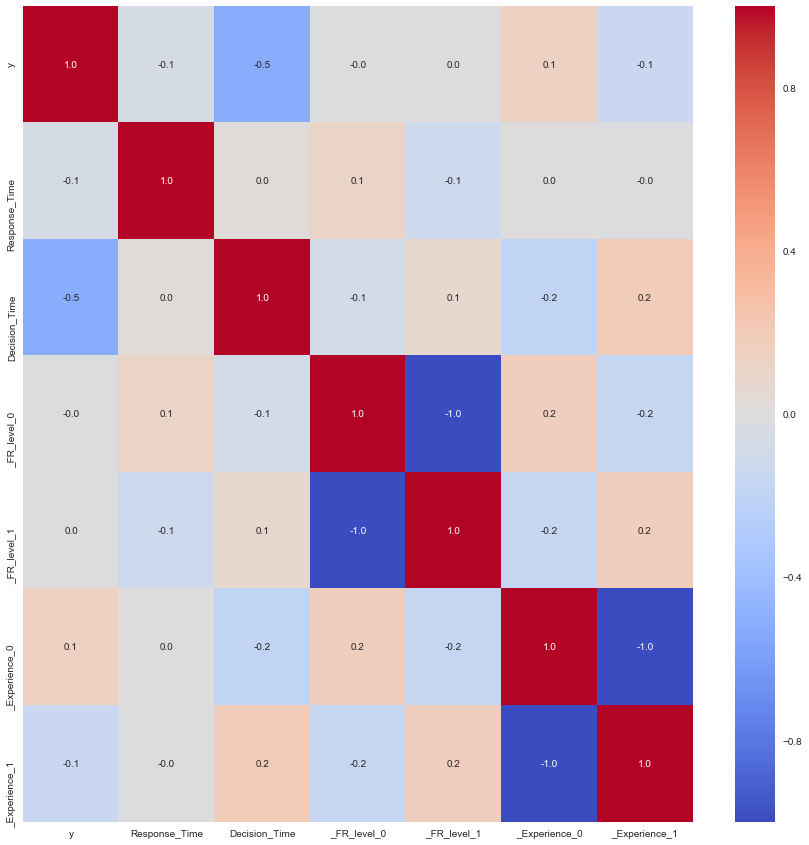

In [197]:
sns.heatmap(all_data.corr(),cmap='coolwarm', ax=plt.subplots(figsize=(15,15))[1], annot = True, fmt = '.1f')

Having low correlation between features is a good sign because it's an indication that, taken seperately, 
the variables bring independant explanatory power to the model. If it was not the case we would have to merge features 
together to avoid what is called multi-colinearity.

The two clear multi-colinearity relations in the graph above are of our own making, ie. **`FR_level_0 - FR_level_1`** and **`Experience_0 - Experience_1 `** which was expected. We'll drop **`FR_level_0`** and **`Experience_0`** from the statsmodels model so that they serve as baselines for our interpretations.

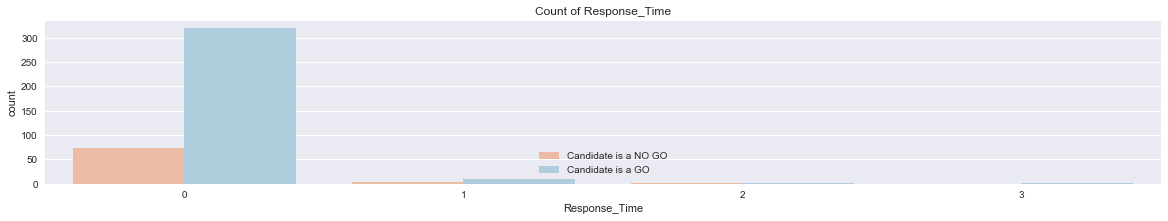

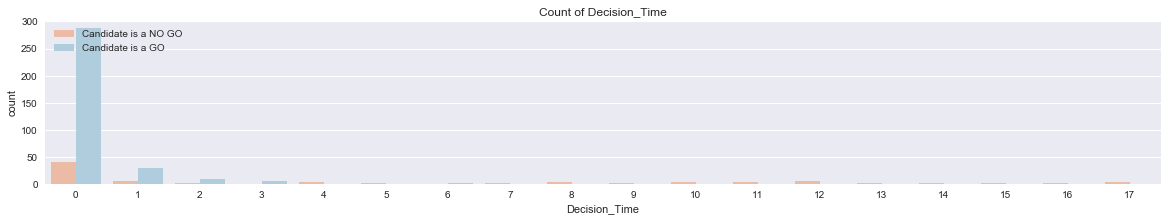

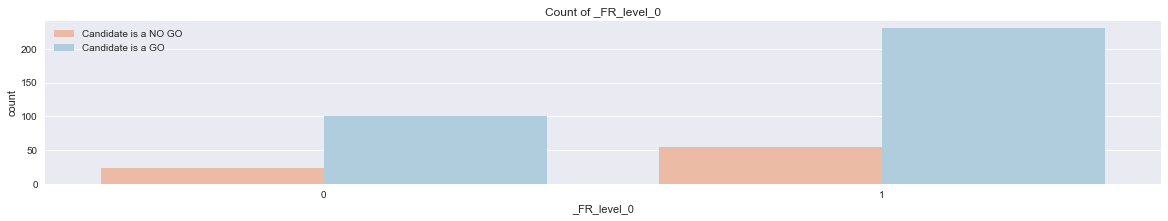

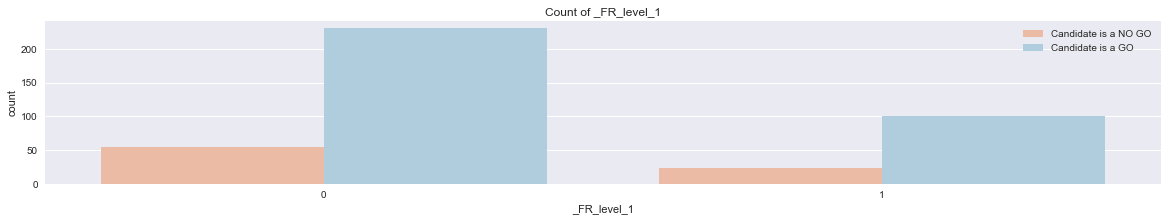

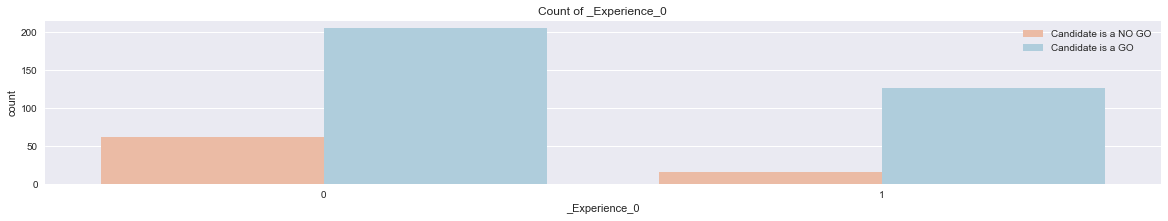

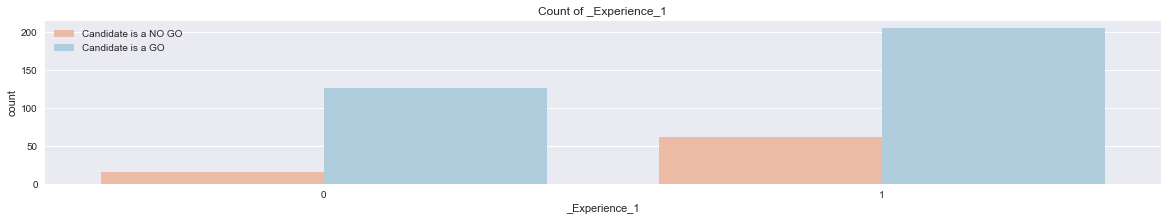

In [198]:
# Let's have a final look and feel for the data before building our model

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

for i, key in enumerate(all_data.columns):
    if key != 'y':
        fig, ax = plt.subplots(figsize=(20, 3))
        plt.title('Count of '+key)
        ax = sns.countplot(x=key, hue= 'y', data=all_data, palette='RdBu')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, ["Candidate is a NO GO", "Candidate is a GO"])
        #ax.set_xticklabels(rotation=30)
        #plt.xticks(rotation=45)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        #ax.set_ylabel('Example', fontsize=40)


## 4. Test the statistical significance of our variables

In [199]:
import statsmodels.api as sm
logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.411973
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  309
Model:                          Logit   Df Residuals:                      305
Method:                           MLE   Df Model:                            3
Date:                Sat, 26 May 2018   Pseudo R-squ.:                  0.1782
Time:                        00:17:25   Log-Likelihood:                -127.30
converged:                       True   LL-Null:                       -154.90
                                        LLR p-value:                 6.215e-12
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Response_Time     0.2387      0.721      0.331      0.740      -1.174       1.651
Decision_Time    -1.

If we look at the table above coef here represents: $\frac{p}{1-p}$ which is the odds

It's worth noting that we have much than the required 100 samples in order to comply with the normal distribution's assumption. We can therefore safely approximate the sample's variance to the variance of the behavior we are modeling.

Based on the output above the resulting model can be summarized as follows:

 $$\frac{p}{1-p} =  β_{FR level} * x_{FR level} + β_{Experience} * x_{Experience} + β_{Decision Time} * x_{Decision Time}$$

where $β_{f}, β_{e}, β_{d}$ are computed in the coef column above

- The odds of a French speaker (**`French_level`**>= B1) getting hired, all else being equal, are ~ 21% higher than a candidate without French fluency
- Similarly, The odds of getting hired if the candidate is a senior candidate with > 6 years of experience, all else being equal, are ~ 97 % higher than a junior profile.
- The odds of getting hired is negatively correlated with the **`Decision time`**

## 5. Split, train and predict/infer on our test set

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # it is possible to fit a linear model to our classification problem but it is not recommended at all 
from sklearn.linear_model import LogisticRegression # scikit learn's log regression uses a certain amount of regularization so set C = 9e10 to suppress the applied regularization
from sklearn.svm import SVC # support vector machine model applied to regression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#randomly split our data into evenly distributed samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

"""
#We're not going to scale because it produces a worse classifier
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
"""

#classifier = LogisticRegression(penalty='l1')
classifier = SVC(kernel ='linear', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(y_pred.size,"""values were successfully predicted""")

93 values were successfully predicted


## 6. Evaluate the model's performance

In [202]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print("confusion_matrix:\n\n",confusion_matrix)

TP = confusion_matrix[0,0]
TN = confusion_matrix[1,1]
FN = confusion_matrix[1,0]
FP = confusion_matrix[0,1]
SUM_ = TP + TN + FN + FP

Accuracy = (TP+FP)/SUM_
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = (2*Precision*Recall)/(Precision+Recall)

"""
# Uncomment to print out the predictions
sub = pd.DataFrame() # cant concatenate on the index because the output from sklearn is a np array without an index
sub['TrueValue']=y_test
sub['LogPrediction']=y_pred
sub['EqualOrNot'] = np.where((sub['TrueValue'] == sub['LogPrediction']), True, False)

timer=time.strftime("%Y%m%d_%H%M%S") # create a variable with current date and time to name the output file

filename='Output_'+timer+'.xlsx'
writer = pd.ExcelWriter(filename)
sub.to_excel(writer,'Log reg', header=True, index=True)

"""

print("""\nAccuracy:{:.2f}\nPrecision:{:.2f}\nRecall:{:.2f}\nF1_score:{:.2f}""".format(Accuracy,Precision,Recall,F1_score))

confusion_matrix:

 [[10  8]
 [ 1 74]]

Accuracy:0.19
Precision:0.56
Recall:0.91
F1_score:0.69


-  Accuracy: among all the samples, how many did we classify correctly? 
-  Precision: how many of the positives did we predict correctly? 
-  Recall: among the samples that are positive, how many of the positives did we predict correctly?
-  F score: harmonic mean of the precision and recall

where 
- TP = True Positives: We correctly predicted the value: Positive
- FP = False Positives: We incorrectly predicted the value: Positive
- FN = False Negatives: We incorrectly predicted the value: Negative
- TN = True Negatives: We correctly predicted the value: Negative

## 7. Visualize the model's decision boundary and sample classification

In [203]:
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

def get(classifier,X,y,Col1,Col2):
    fig = plt.figure(1)
    gridspec.GridSpec(4,4)
    plt.subplot2grid((4,4), (0,0), colspan=2, rowspan=2)
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    X_tmp = X_[[Col1,Col2]].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_, test_size=0.3, random_state=0, stratify=y_)
    classifier.fit(X_train, y_train)
    X_set, y_set = X_train, y_train
    X1, X2 = np.meshgrid(np.arange(start = X_set.iloc[:, 0].min() - 1, stop = X_set.iloc[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set.iloc[:, 1].min() - 1, stop = X_set.iloc[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))

    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    leg = ["Candidate is a NO GO", "Candidate is a GO"]

    for i, item in enumerate(np.unique(y_set)):
        plt.scatter(X_set.values[y_set == item, 0], X_set.values[y_set == item, 1], 
                    c = ListedColormap(('red', 'green'))(i), label = leg[i])
    title = str(classifier)
    index = title.find('(')
    title = title[:index]
    plt.title('Training set:'+str(title))
    plt.xlabel(Col1)
    plt.ylabel(Col2)
    plt.legend()
    
    # large subplot
    plt.subplot2grid((4,4), (0,2), colspan=2, rowspan=2)
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)

    X_tmp = X_[[Col1,Col2]].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_, test_size=0.3, random_state=0)
    classifier.fit(X_test, y_test)
    y_pred = classifier.predict(X_test)
    X_set, y_set = X_test, y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set.iloc[:, 0].min() - 1, stop = X_set.iloc[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set.iloc[:, 1].min() - 1, stop = X_set.iloc[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    
    leg = ["Candidate is a NO GO", "Candidate is a GO"]

    for i, item in enumerate(np.unique(y_set)):
        plt.scatter(X_set.values[y_set == item, 0], X_set.values[y_set == item, 1], 
                    c = ListedColormap(('red', 'green'))(i), label = leg[i])
        
    title = str(classifier)
    index = title.find('(')
    title = title[:index]
    plt.title('Test set:'+str(title))
    plt.xlabel(Col1)
    plt.ylabel(Col2)
    plt.legend()
    
    # fit subplots and save fig
    fig.tight_layout()
    fig.set_size_inches(w=11,h=7)
    #fig_name = str(title)+'.png'
    #fig.savefig(fig_name)

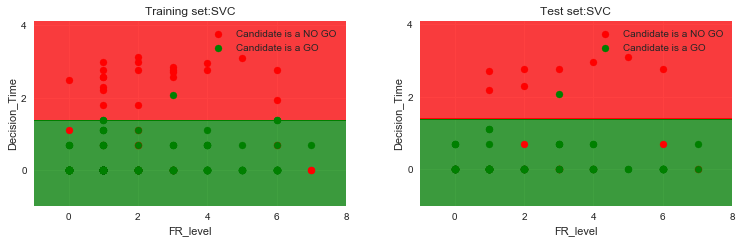

In [204]:
get(SVC(kernel ='linear', random_state=0),X_,y_,'FR_level','Decision_Time')

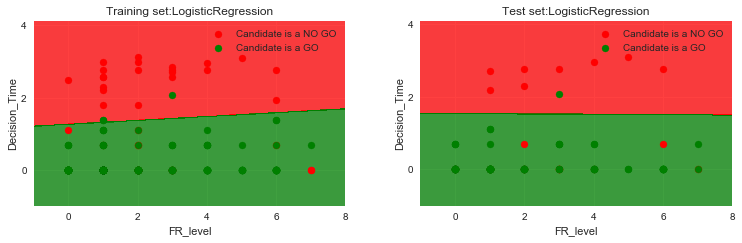

In [205]:
get(LogisticRegression(random_state=0),X_,y_,'FR_level','Decision_Time')

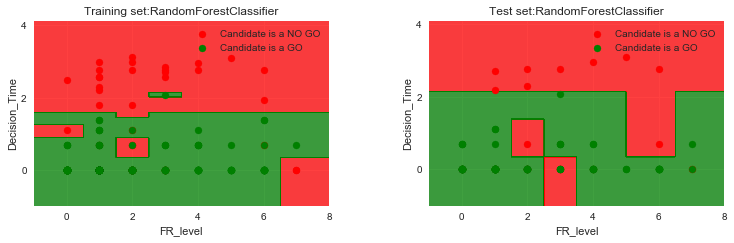

In [206]:
get(RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state=0),X_,y_,'FR_level','Decision_Time')

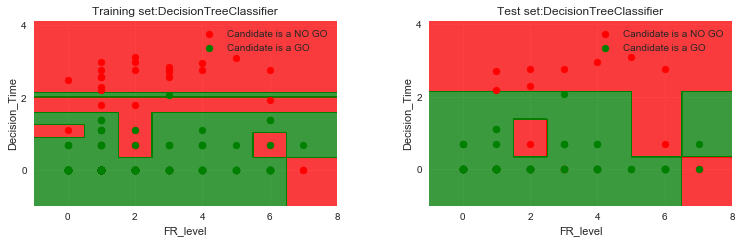

In [207]:
get(DecisionTreeClassifier(criterion = 'entropy'),X_,y_,'FR_level','Decision_Time')

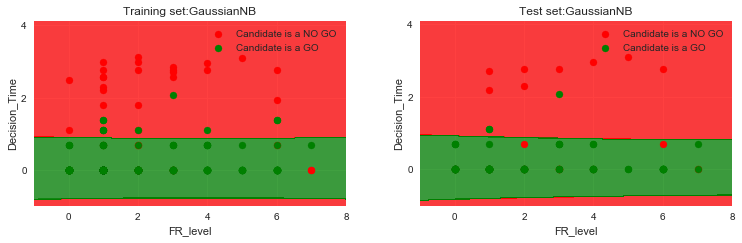

In [208]:
get(GaussianNB(),X_,y_,'FR_level','Decision_Time')

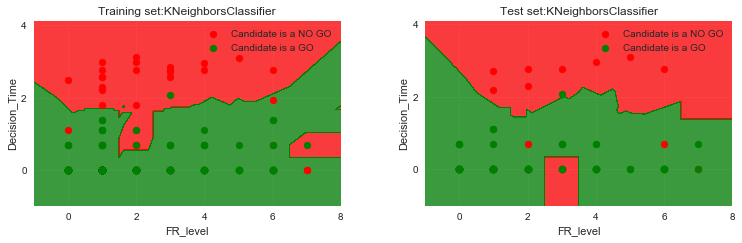

In [209]:
get(KNeighborsClassifier(n_neighbors = 5),X_,y_,'FR_level','Decision_Time')

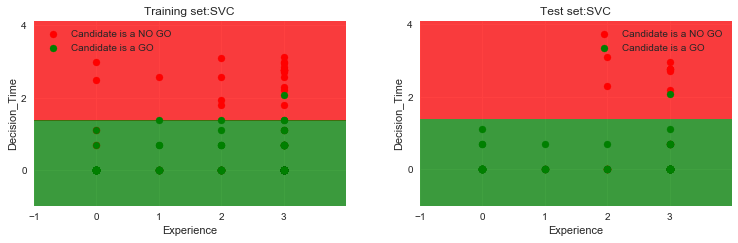

In [210]:
"""
get(RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state=0),X_,y_,'Experience','Decision_Time')
get(DecisionTreeClassifier(criterion = 'entropy'),X_,y_,'Experience','Decision_Time')
get(GaussianNB(),X_,y_,'Experience','Decision_Time')
get(LogisticRegression(),X_,y_,'Experience','Decision_Time')
get(KNeighborsClassifier(n_neighbors = 5),X_,y_,'Experience','Decision_Time')
"""
get(SVC(kernel ='linear', random_state=0),X_,y_,'Experience','Decision_Time')


## 8. Model selection and tuning

The idea behind model selection is to apply Cross-validation and evaluate the performance on a third partition of our set that is not being used to either train the model or test it's performance. The models are ranked and the best is chosen.

We will have to partition our data into 3 sets because everytime we evaluate a model's performance we are fitting the weights to a set of data that cannot be used a second time. Technically you could do it of course but it is not good practice since the resulting model will not generalize well.  

In [211]:
class_list = [RandomForestClassifier(criterion = 'entropy', n_estimators=10, random_state=0),
             DecisionTreeClassifier(criterion = 'entropy'),GaussianNB(),SVC(kernel ='linear', random_state=0),
             KNeighborsClassifier(n_neighbors = 5),LogisticRegression(random_state=0)]

class_dic = {}

def f_score(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_CV)
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_CV, y_pred)
    TP = confusion_matrix[0,0]
    TN = confusion_matrix[1,1]
    FN = confusion_matrix[1,0]
    FP = confusion_matrix[0,1]
    SUM_ = TP + TN + FN + FP
    Accuracy = (TP+FP)/SUM_
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_score = (2*Precision*Recall)/(Precision+Recall)
    #print(F1_score)
    title = str(classifier)
    index = title.find('(')
    title = title[:index]
    class_dic[title]=F1_score

for i in class_list:
    f_score(i)
print(class_dic)
best = 0
best_class = ''

for k, value in class_dic.items():
    if value >= best:
        best_class = k
        best = value

        
print("\nThe best classifier is:",best_class,best)

{'KNeighborsClassifier': 0.25641025641025644, 'LogisticRegression': 0.3846153846153846, 'DecisionTreeClassifier': 0.39999999999999997, 'SVC': 0.3846153846153846, 'RandomForestClassifier': 0.39999999999999997, 'GaussianNB': 0.35714285714285715}

The best classifier is: RandomForestClassifier 0.39999999999999997


### Tuning our model with GridSearchCV

Let us re-apply the logistic model with multiple tuning possibilities and assess the best parameters that will maximize our performance. In practice what we'll do is split into k folds ie partitions and evaluating our model across a range of parameters. 

These parameters are 
- C: which is the regularization parameter of our cost function
- The Penalty parameter which takes two values: l1 and l2

For a deeper evaluation of regularization and the math behind it I highly recommend Andrew Ng's Machine learning class on Coursera <a href="https://www.coursera.org/learn/machine-learning">link</a> 


In [212]:
"""
from sklearn.grid_search import GridSearchCV

list_test = np.arange(start = 0.01, stop = 10, step = 0.1).tolist()
penalty = ['l1', 'l2']

param_grid = {'C':list_test,'penalty':penalty}
grid = GridSearchCV(LogisticRegression(),param_grid, scoring='precision')
grid.fit(X,y)
print(grid.best_score_)
print(grid.best_params_)
#print(grid.best_estimator_)
#print(grid.grid_scores_)
""";

In [213]:
"""
from sklearn.grid_search import GridSearchCV
from sklearn import svm, grid_search

Cs = np.arange(start = 0.01, stop = 10, step = 0.1).tolist()
gammas = np.arange(start = 0.01, stop = 10, step = 0.1).tolist()
#nfolds = np.arange(start = 1, stop = 10, step = 1).tolist()

param_grid = {'C': Cs, 'gamma' : gammas}
grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=10)
grid.fit(X,y)
print(grid.best_score_)
print(grid.best_params_)
#print(grid.best_estimator_)
#print(grid.grid_scores_)
""";

## 9. Key take aways


1) Our scikit-learn model tells us that:
- **`Experience`**, **`French_level`** and **`Decision time`** are good predictors of the hiring decision. **`Response time`** is unfortunately not a good predictor of the hiring decision
- **`Experience`** and **`French_level`** are positively correlated with the decision to hire, **`Decision time`** is negatively correlated with the decision to hire
- Regardless of the **`Experience`** of the candidate, if the **`Decision time`** is higher than 1.8 which corresponds to 36 calendar days then the candidate won't be hired. To be more specific, if the **`Decision time`** is higher than 36 calendar days then the odds of getting hired are lower than 1%. This assertion is statistically significant as verified with the p-value (<1%) featured above

The null hypothesis ie. "the **`Decision time`** variable has no effect on the GO/NO GO decision" can safely be rejected as the means and standard deviation of both distributions are significantly different in both samples
ie. The mean and standard deviation of the **`Decision time`** distribution where y=1 vs the mean and std of the **`Decision time`** distribution where y=0 are significantly different

2) From our statsmodels.api library we found that:
- The odds of a French speaker (**`French_level`**>= B1) getting hired, all else being equal, are ~ 21% higher than a candidate without French fluency
- Similarly, The odds of getting hired if the candidate is a senior candidate with > 6 years of experience, all else being equal, are ~ 97 % higher than a junior profile.
- The odds of getting hired is negatively correlated with the **`Decision time`**

3) We expected to choose a model through cross-validation but the f score of the cross-validation set was too low to take it into consideration when choosing a model. We've therefore stuck with the SVC classifier


## 10. Conclusion

It's been quite a journey and I'll probably keep on evolving this model as I learn more about automation and ML. 
There is probably a lot of mistakes in here so if you spot any fire away :)

The improvements I intend to bring to the model in the near future are:

A. Defining these features which would definitely help us in terms of performance: 
1. The number of relevant years of experience in a given field instead of the total years of experience
2. CV coherence: The client prefers stable and meaningful experiences as opposed to someone who changed 
fields/technologies frequently
3. Fit with the position: FR level and job requirements eg. technologies
4. Decision maker: there are several decision makers within the client's premises, mapping this information might help with the performance
5. Number of relatives working in the company: this might be cliché and I probably won't be able to map this feature just yet but keeping it on our back log does not hurt

B. Other options to improve performance include: 
2. Get more training samples
1. Increase the complexity by applying ensembling/ boosting or even a neural network

### To be continued